# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# План выполнения проекта:
1. Загрузим и изучим данные.
2. Проведем предобработку данных при необходимости: заполнение пропущенных значений (при наличии пропусков), обработка аномалий в столбцах, определение неинформативных признаков и их удаление.
3. Подготовим выборки для обучения моделей.
4. Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.
5. Проанализируем время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

# Условия:

- Для оценки качества моделей применять метрику RMSE. RMSE должно быть меньше 2500.
- Освоить библиотеку LightGBM и её средствами построить модели градиентного бустинга.
- Вывести время выполнения ячейки кода специальной командой
- Не ограничиваться градиентным бустингом
- В модели градиентного бустинга лучше изменять только два-три параметра, так как модель может долго обучаться.

# Описание данных:
**Признаки**:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**:
- Price — цена (евро)

## Подготовка данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OrdinalEncoder
import time

import warnings
#убираем системные предупреждения
warnings.filterwarnings('ignore')

### Обзор данных

Считаем данные из csv-файла в датафрейм и сохраним в переменную

In [2]:
data_avto = pd.read_csv('/datasets/autos.csv')

In [3]:
display(data_avto.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
display(data_avto.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [5]:
data_avto.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
pd.DataFrame(round(data_avto.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,10.600000
RegistrationYear,0.000000
Gearbox,5.600000
Power,0.000000
Model,5.600000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.300000


**Вывод по шагу 1.1**:
1. Данные загружены и изучены
2. Есть признаки, которые никак не влияют на стоимость автомобиля - DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen - эти неинформативные столбцы надо удалить перед предобработкой данных.
3. В целевом признаке Price минимальное значение 0, аналогично и в признаках Power и RegistrationMonth. Столбец RegistrationMonth мы будем удалять, в других посмотрим на выбросы на этапе предобработки данных.
4. В столбце RegistrationYear также присутствуют выбросы(минимальное значение 1000 и максимальное 9999). Эти выбросы тоже необходимо проанализировать в дальнейшем.
5. Названия столбцов необходимо привести к змеиному стилю.
6. Есть пропуски, которые требуется обработать на следующих шагах.

### Замена названия столбцов

In [7]:
# выведем текущее наименование столбцов
data_avto.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [8]:
# приведем названия столбцов к нижнему регистру
data_avto.columns = data_avto.columns.str.lower()
data_avto.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [9]:
# приведем названия столбцов к змеиному стилю
data_avto.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

In [10]:
# проверим изменения
data_avto.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

**Вывод по шагу 1.2**:

Названия столбцов приведены к нижнему регистру и змеиному стилю.

### Определение неинформативных столбцов и их удаление

На предыдущем шаге мы определили неинформативные столбцы ( DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen), информация в которых не влияет на стоимость автомобиля. Удалим эти столбцы.

In [11]:
data_avto.drop(columns=['date_crawled', 'date_created', 'registration_month',
                    'number_of_pictures', 'postal_code', 'last_seen'],
           axis=1,
           inplace=True)

In [12]:
# проверим изменения
data_avto.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [13]:
print('\nЧисло дубликатов:', data_avto.duplicated().sum())


Число дубликатов: 45040


**Вывод по шагу 1.3**:
1. удалены неинформативные столбцы.
2. выявленные дубликаты могут быть не дубликатами в прямом смысле, так как были удалены некоторые данные. В данном случае, по одной и той же марке машины может совпадать годы выпуска, тип коробки передач, мощность, тип топлива и т.д. Поэтому выявленные дубликаты удалять не будем.

### Обработка пропусков

In [14]:
data_avto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [15]:
pd.DataFrame(round(data_avto.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,10.600000
registration_year,0.000000
gearbox,5.600000
power,0.000000
model,5.600000
kilometer,0.000000
fuel_type,9.300000
brand,0.000000
repaired,20.100000


#### Столбец price

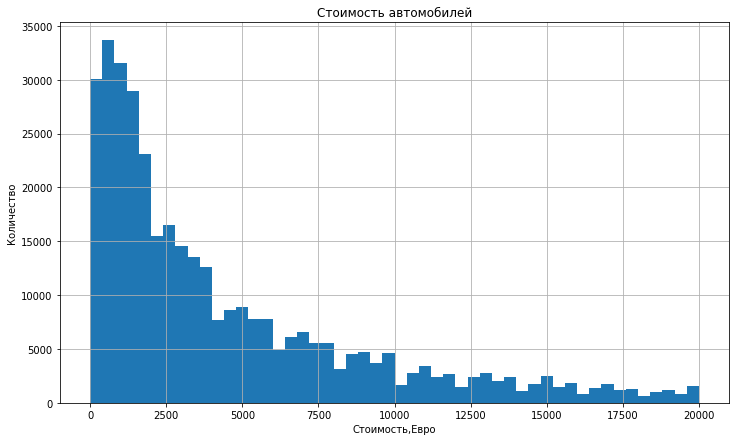

In [16]:
# посторим гистограмму по столбцу price
data_avto.price.hist(bins=50,figsize=(12,7))
plt.title('Стоимость автомобилей')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()

In [17]:
data_avto.loc[data_avto['price'] < 10]['price'].count() # определим сколько машин по цене, ниже 10 Евро.

12028

Цену, меньше 10 евро, будем считать неприемлемой, поэтому необходимо исключить данные выбросы.

In [18]:
data_avto = data_avto.query('price> 10')

In [19]:
data_avto.loc[data_avto['price'] < 10]['price'].count()

0

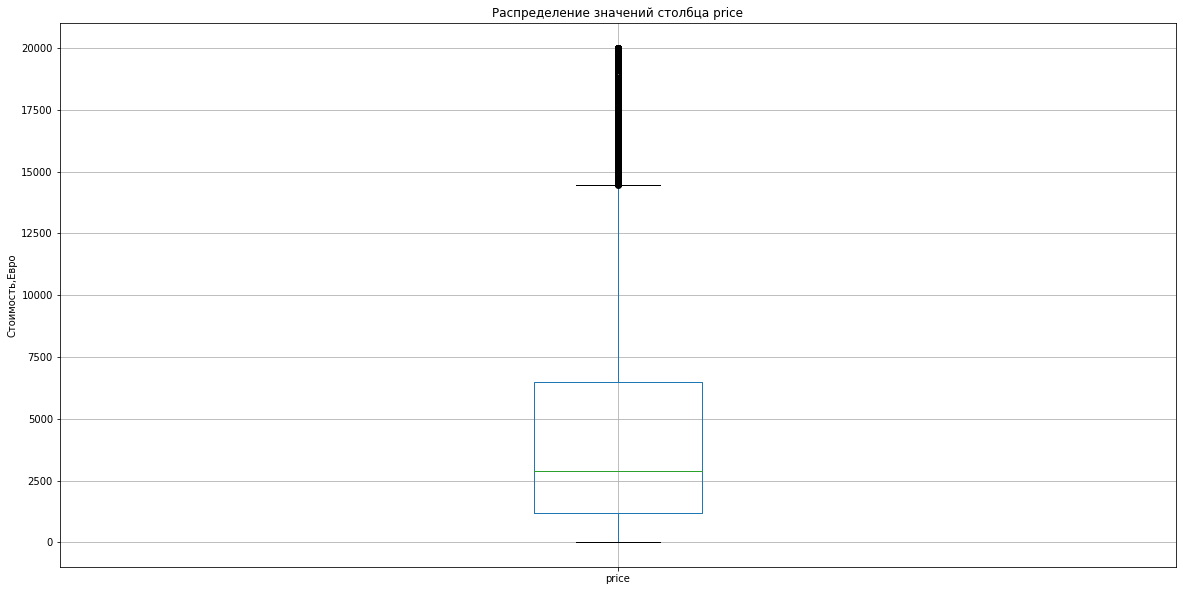

In [20]:
data_avto.boxplot(['price'],figsize=(20,10))
plt.title('Распределение значений столбца price')
plt.ylabel('Стоимость,Евро')
plt.show()

#### Столбец vehicle_type

In [21]:
# здесь присутствует много пропусков - 9,7%. Заменим пропущенные значения на unknown
data_avto.fillna({'vehicle_type':'unknown'}, inplace=True)

In [22]:
data_avto.vehicle_type.value_counts()

sedan          89190
small          77828
wagon          63533
unknown        33202
bus            28278
convertible    19824
coupe          15574
suv            11768
other           3060
Name: vehicle_type, dtype: int64

#### Столбец registration_year	

Пропуски в данном столбце отсутствуют, проверим выбросы.

In [23]:
data_avto_years = data_avto.groupby('registration_year')['price'].agg('count').reset_index()
data_avto_years.columns = ['registration_year', 'count']
data_avto_years

,registration_year,count
0,1000,28
1,1001,1
2,1039,1
3,1111,1
4,1234,4
...,...,...
134,8500,1
135,8888,1
136,9000,2
137,9450,1


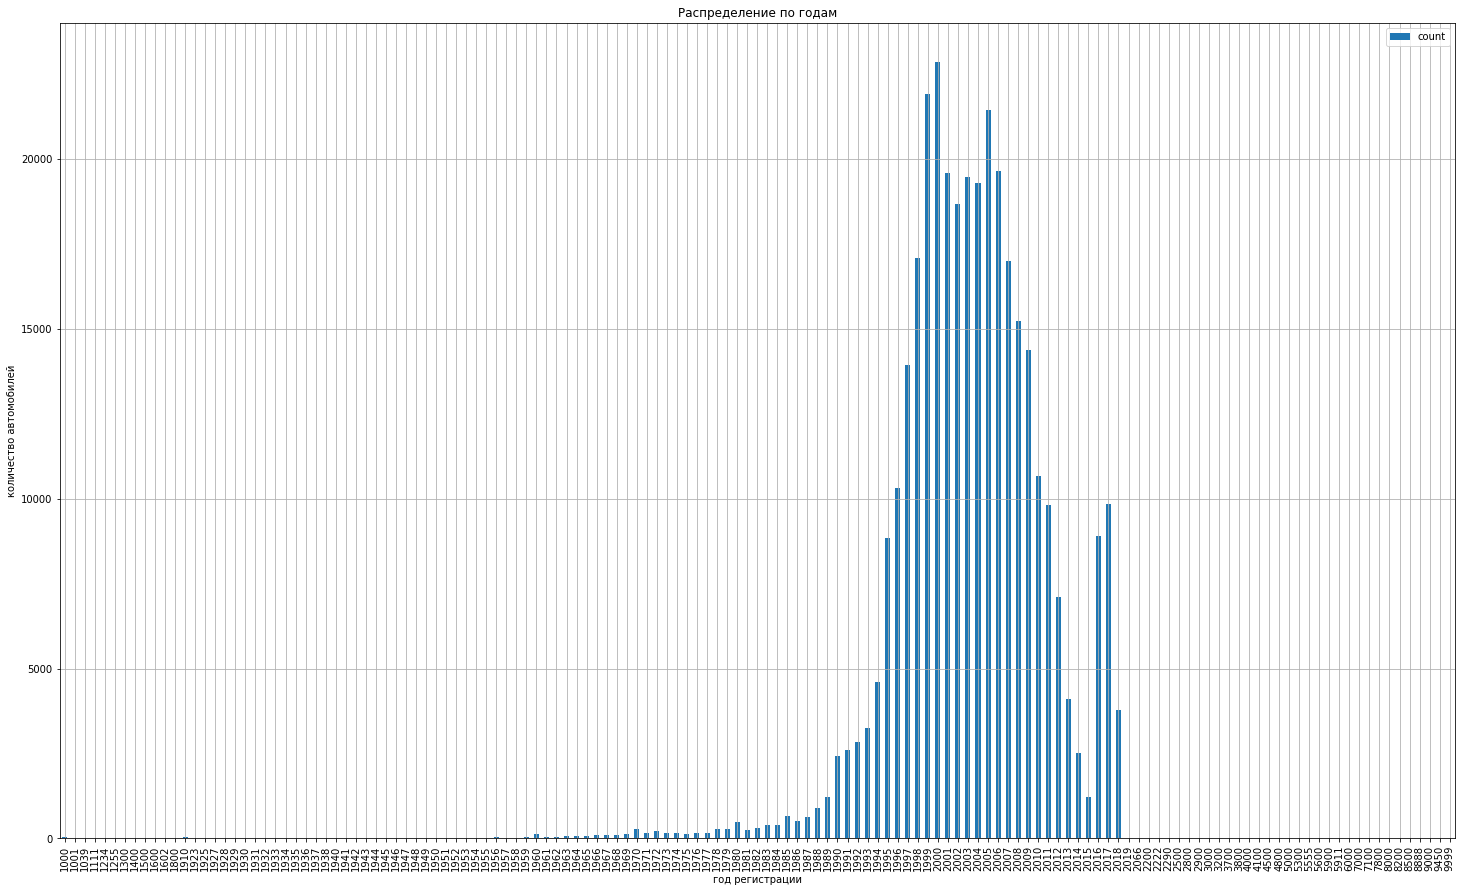

In [24]:
# построим гистограмму
data_avto_years.plot.bar(x = 'registration_year', y = 'count', grid=True, title='Распределение по годам',
                   figsize=(25,15)).set(xlabel='год регистрации', ylabel='количество автомобилей');

In [25]:
data_avto['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1956, 3200,
       1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940,
       3000, 2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1400, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934,
       1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931, 4500,
       1602, 7800, 1947, 1927, 7100, 8200, 1946])

In [26]:
data_avto=data_avto.query('registration_year >= 1923 & registration_year <= 2016')

К продаже могут быть представлены так называемые "ретро"-автомобили, поэтому период регистрации автомобиля взяли с 1923.
Проверим, как выглядит график после проведенных изменений.

In [27]:
data_avto_years = data_avto.groupby('registration_year')['price'].agg('count').reset_index()
data_avto_years.columns = ['registration_year', 'count']
data_avto_years

,registration_year,count
0,1923,2
1,1925,1
2,1927,1
3,1928,2
4,1929,6
...,...,...
86,2012,7114
87,2013,4090
88,2014,2500
89,2015,1210


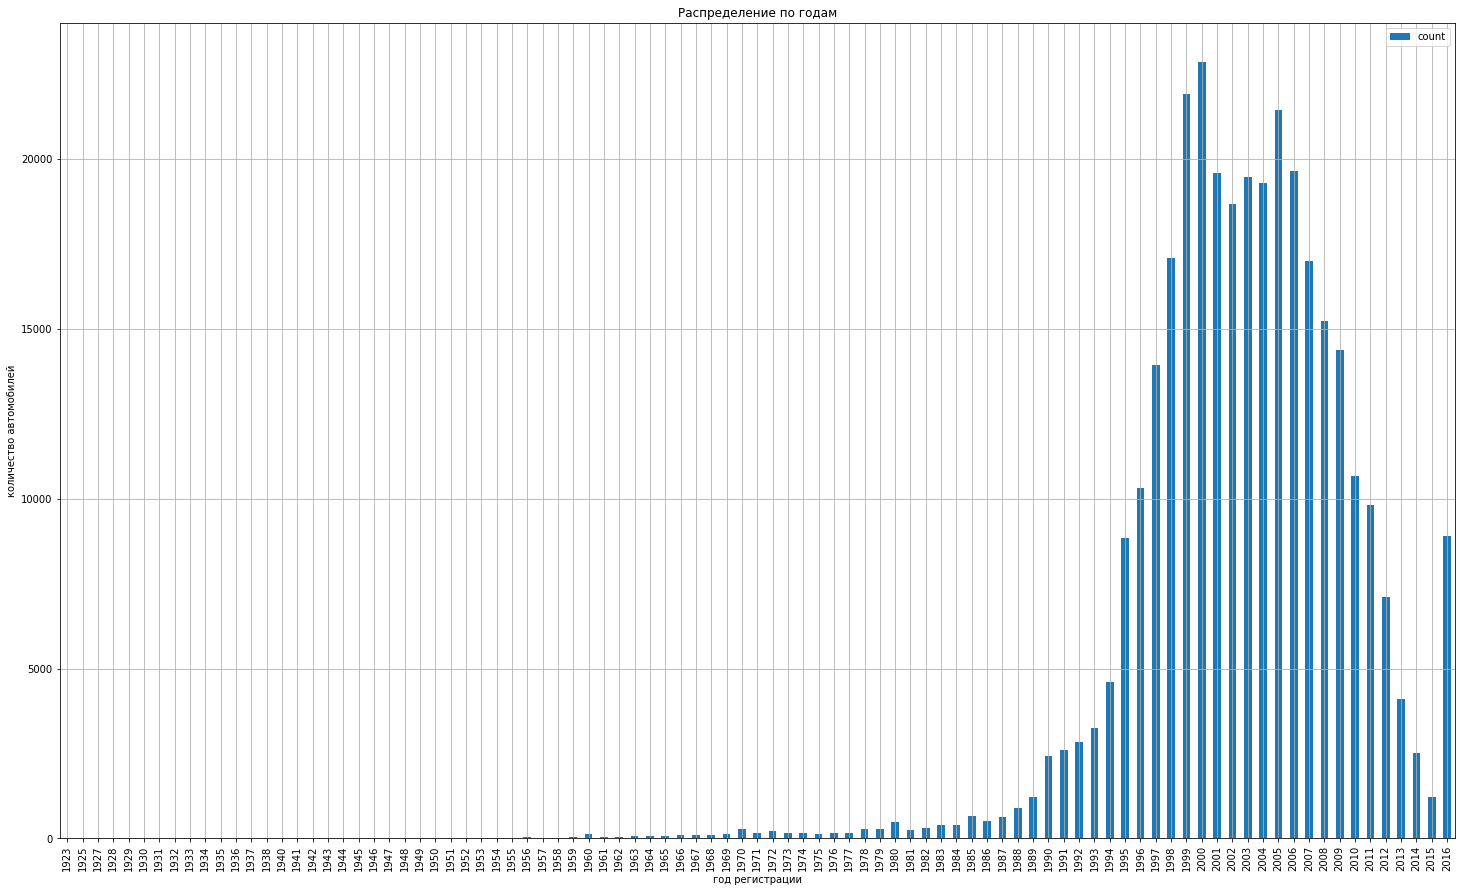

In [28]:
# построим гистограмму
data_avto_years.plot.bar(x = 'registration_year', y = 'count', grid=True, title='Распределение по годам',
                   figsize=(25,15)).set(xlabel='год регистрации', ylabel='количество автомобилей');

#### Столбец gearbox

In [29]:
data_avto['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

В данном столбце присутствуют пропуски (они составляют 5,6% ,это немного). К тому же информация о корбкe передач достаточно важный параметр при покупке/продаже автомобиля. В связи с этим, лучше удалить эти данные, чем заполнить пропуски каким-то значением.

In [30]:
data_avto.dropna(subset=['gearbox'], inplace=True)

In [31]:
# посмотрим на результат
data_avto['gearbox'].unique()

array(['manual', 'auto'], dtype=object)

#### Столбец power

В данном столбце пропуски отсутствуют. Проверим выбросы.

In [32]:
data_avto['power'].describe()

count    313316.000000
mean        115.622831
std         184.828265
min           0.000000
25%          75.000000
50%         107.000000
75%         144.000000
max       20000.000000
Name: power, dtype: float64

In [33]:
data_avto['power'].value_counts()

0       22475
75      21558
60      14364
150     13515
101     12190
        ...  
416         1
1079        1
6045        1
671         1
1653        1
Name: power, Length: 675, dtype: int64

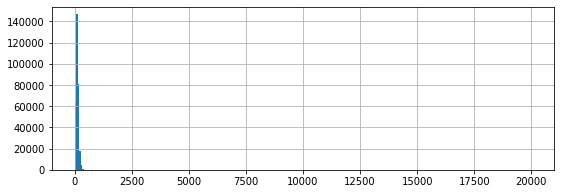

In [34]:
data_avto.power.hist(bins=300,figsize=(9,3))
plt.show()

Очевидно, что мощностей, равных 0, не бывает. Удалим эти данные.

In [35]:
data_avto=data_avto.query('power >0 & power < 2030') # внесены исправления по верхней границе

In [36]:
data_avto['power'].value_counts()

75      21558
60      14364
150     13515
101     12190
140     12185
        ...  
1200        1
1968        1
1625        1
1202        1
398         1
Name: power, Length: 591, dtype: int64

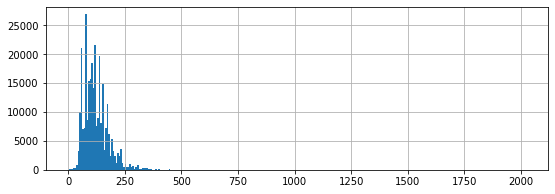

In [37]:
data_avto.power.hist(bins=300,figsize=(9,3))
plt.show()

#### Столбец model

В данном столбце присутствуют пропуски (5,6%). Их немного, также модель - это важный фактор при выборе автомобиля, поэтому менять пропуски в данном столбце на какое-либо значение будет неправильным, удалим отсутствующие значения из наших данных. Также проверим на выбросы.

In [38]:
data_avto.dropna(subset=['model'], inplace=True)

In [39]:
data_avto['model'].unique()

array(['grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max', '3_reihe',
       'passat', 'navara', 'twingo', 'a_klasse', 'scirocco', '5er',
       'arosa', 'other', 'civic', 'transporter', 'punto', 'e_klasse',
       'clio', 'kadett', 'one', 'fortwo', '1er', 'b_klasse', 'a8',
       'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       'astra', '156', 'escort', 'forester', 'xc_reihe', 'scenic', 'a1',
       'focus', 'a4', 'tt', 'a6', 'jazz', 'omega', 'polo', 'slk', '7er',
       'combo', 'corsa', '80', '147', 'z_reihe', 'sorento', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'insignia', 'ka', 'almera',
       'megane', 'a3', 'lupo', 'r19', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus', 'fox',
       'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider', 'cuore',
       's_max', 

#### Столбец kilometer

В данном столбце пропусков нет. Данные готовы для обучения.

In [40]:
data_avto['kilometer'].value_counts()

150000    185408
125000     30351
100000     12218
90000       9865
80000       8653
70000       7473
60000       6577
50000       5433
40000       4318
30000       3720
20000       3036
5000        2369
10000        863
Name: kilometer, dtype: int64

#### Столбец fuel_type

In [41]:
# здесь присутствует много пропусков - 9,3%. Заменим пропущенные значения на unknown
data_avto.fillna({'fuel_type':'unknown'}, inplace=True)

In [42]:
data_avto['fuel_type'].value_counts()

petrol      178344
gasoline     84935
unknown      11880
lpg           4359
cng            462
hybrid         178
other           72
electric        54
Name: fuel_type, dtype: int64

#### Столбец brand

Пропуски в данном столбце отсутствуют. С данными все в порядке.

In [43]:
data_avto['brand'].value_counts()

volkswagen       60980
bmw              30802
opel             30736
mercedes_benz    26313
audi             24632
ford             19791
renault          13275
peugeot           8762
fiat              7253
seat              5652
skoda             4839
mazda             4483
citroen           4057
toyota            3867
nissan            3858
smart             3671
hyundai           2960
mini              2896
volvo             2724
mitsubishi        2366
honda             2241
kia               1988
alfa_romeo        1870
suzuki            1869
chevrolet         1389
chrysler          1101
dacia              780
subaru             614
porsche            599
daihatsu           586
jeep               557
saab               456
land_rover         452
jaguar             431
daewoo             380
lancia             360
rover              315
trabant            229
lada               150
Name: brand, dtype: int64

#### Столбец repaired

В данном столбце много пропусков (20,1%).

In [44]:
data_avto['repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

In [45]:
data_avto['repaired'].isna().sum()

37096

In [46]:
# очевидно, что отсутствующие данные лучше заменить на unknown
data_avto.fillna({'repaired':'unknown'}, inplace=True)

In [47]:
data_avto['repaired'].unique()

array(['unknown', 'no', 'yes'], dtype=object)

**Вывод по шагу 1.4**:

Пропуски обработаны.

In [48]:
pd.DataFrame(round(data_avto.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,0.000000
registration_year,0.000000
gearbox,0.000000
power,0.000000
model,0.000000
kilometer,0.000000
fuel_type,0.000000
brand,0.000000
repaired,0.000000


In [49]:
data_avto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280284 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              280284 non-null  int64 
 1   vehicle_type       280284 non-null  object
 2   registration_year  280284 non-null  int64 
 3   gearbox            280284 non-null  object
 4   power              280284 non-null  int64 
 5   model              280284 non-null  object
 6   kilometer          280284 non-null  int64 
 7   fuel_type          280284 non-null  object
 8   brand              280284 non-null  object
 9   repaired           280284 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.5+ MB


# **Общий вывод по шагу 1**:

1. Данные загружены и изучены
2. Названия столбцов приведены к нижнему регистру и змеиному стилю.
3. Удалены неинформативные столбцы - DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen.
4. В столбцах vehicle_type, fuel_type и repaired значения заменены на unknown.
5. В столбцах gearbox и model пропущенные данные были удалены.
6. В столбцах price, registration_year и power избавились от выбросов.
7. В результате обработки данных датафрейм сократился, но 288805 строк достаточно для обучения.

## Обучение моделей

In [50]:
# сбросим индексы после удаления неинформативных столбцов
data_avto = data_avto.reset_index(drop=True)
data_avto.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
3,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [51]:
data_avto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280284 entries, 0 to 280283
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              280284 non-null  int64 
 1   vehicle_type       280284 non-null  object
 2   registration_year  280284 non-null  int64 
 3   gearbox            280284 non-null  object
 4   power              280284 non-null  int64 
 5   model              280284 non-null  object
 6   kilometer          280284 non-null  int64 
 7   fuel_type          280284 non-null  object
 8   brand              280284 non-null  object
 9   repaired           280284 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.4+ MB


In [52]:
# выделим признаки и целевой признак
features = data_avto.drop(['price'], axis=1)
target = data_avto['price']

Необходимо обучить модели. Применим следующие алгоритмы обучения:
- LinearRegression
- RandomForestRegressor
- CatBoostRegressor
- LightGBMRegressor

In [53]:
# для расчёта целевой метрики используем RMSE и напишем функцию.
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

In [54]:
# напишем функцию, котторая будет собирать данные, важные для заказчика, в сводную таблицу для анализа
def avto_table(RMSE,l_time,p_time,model_name,data_avto):
    data_avto.loc[model_name,'Model'] = model_name
    data_avto.loc[model_name,'RMSE'] = RMSE
    data_avto.loc[model_name,'Time of learn'] = l_time
    data_avto.loc[model_name,'Predict time'] = p_time
    return data_avto

In [55]:
# это будет сводная таблица
avto_result = pd.DataFrame(columns=['Model','RMSE','Time of learn','Predict time'])
avto_result

,Model,RMSE,Time of learn,Predict time


In [56]:
# разделим на обучающую, валидационную и тестовую выборки
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.3, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)

Применим кодирование текстовых данных в категориальные цифровые значения методом OrdinalEncoder.

In [57]:
# выберем только категориальные признаки
cat_columns=['vehicle_type', 'gearbox','model',
       'fuel_type', 'brand', 'repaired']

In [58]:
#encoder = OrdinalEncoder()
#encoder.fit(features[col])
#features_ord=features.copy()
#features_ord[col]= pd.DataFrame(encoder.transform(features[col]), columns = features[col].columns)

In [59]:
# проверим результат
#features_ord.head()

```python
# порядковое кодирование (для "деревянных моделей")
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = [список всех категориальных признаков]
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])
```

In [60]:
# порядковое кодирование (для "деревянных моделей")
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

In [61]:
#features_train, features_test, target_train, target_test = train_test_split(features_ord, target, test_size=0.25, random_state=12345)

In [62]:
# У признаков разный масштаб. Необходимо их стандартизировать.
numeric = ['registration_year','power','kilometer','vehicle_type','gearbox','model','fuel_type','brand', 'repaired']
scaler = StandardScaler()
scaler.fit(features_train_ord[numeric]) 
features_train_ord[numeric] = scaler.transform(features_train_ord[numeric])
features_valid_ord[numeric] = scaler.transform(features_valid_ord[numeric])
features_test_ord[numeric] = scaler.transform(features_test_ord[numeric])

In [63]:
features_train_ord.head() # проверка

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
72549,-0.233364,-1.255025,0.503704,-0.331716,-1.116029,-0.090010,0.644702,-1.480710,-0.50549
9350,1.427910,-1.413166,0.503704,-0.300006,0.183528,-1.321365,0.644702,0.968268,-0.50549
53927,0.181954,-1.887590,0.503704,-0.981774,0.819180,-0.090010,0.644702,0.356024,-0.50549
15945,1.427910,0.326389,0.503704,-0.093891,-0.904145,0.594076,-1.478562,1.121329,-0.50549
238391,-1.479319,0.642671,0.503704,0.445181,-0.155487,-1.047730,0.644702,1.274390,-0.50549


In [64]:
# прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
# после прямого кодирования кол-во признаков в выборках будет отличаться
# поэтому стоит удалить лишние признаки в каждой выборке

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

# Оставим в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

### LinearRegression

In [65]:
%%time
start = time.time()
model_lr=LinearRegression(normalize=True) # объявляем модель
model_lr.fit(features_train_ohe, target_train) # обучаем модель
end = time.time()
time_of_learn_lr=round(end-start,2)

CPU times: user 12.5 s, sys: 6.78 s, total: 19.3 s
Wall time: 19.6 s


In [66]:
%%time
start = time.time()
predict_lr = model_lr.predict(features_valid_ohe) # получение предсказания модели
end = time.time()
time_of_pr_lr=round(end-start,2)

CPU times: user 123 ms, sys: 128 ms, total: 250 ms
Wall time: 288 ms


In [67]:
print(' Гиперпараметры модели:\n',model_lr)

 Гиперпараметры модели:
 LinearRegression(normalize=True)


In [68]:
rmse_lr=rmse(target_valid, predict_lr)
print('RMSE модели Линейная Регрессия равна:', rmse_lr)

RMSE модели Линейная Регрессия равна: 2613.0


In [69]:
avto_table(rmse_lr,time_of_learn_lr,time_of_pr_lr,'LinearRegression',avto_result) # добавим данные в сводную таблицу

,Model,RMSE,Time of learn,Predict time
LinearRegression,LinearRegression,2613.0,19.56,0.29


```python
# прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
# после прямого кодирования кол-во признаков в выборках будет отличаться
# поэтому стоит удалить лишние признаки в каждой выборке

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

# Оставим в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]
```

### RandomForestRegressor

In [70]:
%%time
start = time.time()
model_forest= RandomForestRegressor(n_estimators=100, max_depth=5, random_state=12345) # объявляем модель
model_forest.fit(features_train_ord, target_train) # обучаем модель
end = time.time()
time_of_learn_forest=round(end-start,2)

CPU times: user 15.2 s, sys: 72.5 ms, total: 15.3 s
Wall time: 15.3 s


In [71]:
%%time
start = time.time()
predict_forest = model_forest.predict(features_valid_ord) # получение предсказания модели
end = time.time()
time_of_pr_forest=round(end-start,2)

CPU times: user 171 ms, sys: 0 ns, total: 171 ms
Wall time: 179 ms


In [72]:
print(' Гиперпараметры модели:\n',model_forest)

 Гиперпараметры модели:
 RandomForestRegressor(max_depth=5, random_state=12345)


In [73]:
rmse_forest=rmse(target_valid, predict_forest)
print('RMSE модели Случайный лес равна:', rmse_forest)

RMSE модели Случайный лес равна: 2362.42


In [74]:
# добавим данные в сводную таблицу
avto_table(rmse_forest,time_of_learn_forest,time_of_pr_forest,'RandomForestRegressor',avto_result) 

,Model,RMSE,Time of learn,Predict time
LinearRegression,LinearRegression,2613.0,19.56,0.29
RandomForestRegressor,RandomForestRegressor,2362.42,15.3,0.18


### CatBoostRegressor

In [75]:
%%time
best_result = 5000
depth = 0
depths = []
results = []

for depth in range(1, 21, 5):
    model_catboost = CatBoostRegressor(iterations=30, learning_rate=0.4, max_depth=depth, random_state=12345, verbose=5)
    model_catboost.fit(features_train_ord, target_train)
    predictions_valid = model_catboost.predict(features_valid_ord)
    result = rmse(target_valid, predictions_valid)
    depths.append(depth)
    results.append(result)
   
    if result < best_result:
        best_depth = depth
        best_result = result

display(best_result, best_depth)

0:	learn: 4030.4557043	total: 74ms	remaining: 2.14s
5:	learn: 3068.2671575	total: 189ms	remaining: 758ms
10:	learn: 2741.2622500	total: 297ms	remaining: 513ms
15:	learn: 2591.7174199	total: 383ms	remaining: 335ms
20:	learn: 2495.4849933	total: 468ms	remaining: 201ms
25:	learn: 2439.7085053	total: 552ms	remaining: 85ms
29:	learn: 2406.3845469	total: 623ms	remaining: 0us
0:	learn: 3495.9755769	total: 35.4ms	remaining: 1.02s
5:	learn: 2134.6140998	total: 187ms	remaining: 748ms
10:	learn: 1937.8456095	total: 329ms	remaining: 568ms
15:	learn: 1862.3160516	total: 469ms	remaining: 410ms
20:	learn: 1808.9629945	total: 611ms	remaining: 262ms
25:	learn: 1780.6842364	total: 744ms	remaining: 114ms
29:	learn: 1754.2376854	total: 855ms	remaining: 0us
0:	learn: 3371.8955952	total: 65.6ms	remaining: 1.9s
5:	learn: 1876.0948074	total: 419ms	remaining: 1.68s
10:	learn: 1730.7561364	total: 750ms	remaining: 1.29s
15:	learn: 1672.8705785	total: 1.08s	remaining: 942ms
20:	learn: 1636.4539116	total: 1.42s	re

1571.06

16

CPU times: user 24.6 s, sys: 15.3 s, total: 39.9 s
Wall time: 42.3 s


Значение `verbose=5` означает, что при обучении модели будут выводиться более подробные сообщения о процессе обучения. Значение `verbose=5` может быть полезно для мониторинга процесса обучения, отладки и оптимизации параметров модели. Однако, такое высокое значение `verbose` может быть слишком многословным и неудобным в случае больших объемов данных.

In [76]:
%%time
start = time.time()
model_catboost = CatBoostRegressor(iterations=30, learning_rate=0.4, max_depth=16, random_state=12345, verbose=5)
model_catboost.fit(features_train_ord, target_train, eval_set=(features_valid_ord,target_valid))
end = time.time()
time_of_learn_catboost=round(end-start,2)

0:	learn: 3327.6743305	test: 3315.5641719	best: 3315.5641719 (0)	total: 1.17s	remaining: 33.9s
5:	learn: 1715.1128845	test: 1758.8678731	best: 1758.8678731 (5)	total: 6.9s	remaining: 27.6s
10:	learn: 1573.6097596	test: 1653.4789096	best: 1653.4789096 (10)	total: 12.7s	remaining: 22s
15:	learn: 1519.0851273	test: 1621.7547553	best: 1621.7547553 (15)	total: 18.6s	remaining: 16.3s
20:	learn: 1476.0408795	test: 1596.5470821	best: 1596.5470821 (20)	total: 24.5s	remaining: 10.5s
25:	learn: 1437.1167985	test: 1579.8254310	best: 1579.8254310 (25)	total: 30.4s	remaining: 4.67s
29:	learn: 1414.4981269	test: 1571.0623785	best: 1571.0623785 (29)	total: 35.1s	remaining: 0us

bestTest = 1571.062378
bestIteration = 29

CPU times: user 20.6 s, sys: 14.6 s, total: 35.3 s
Wall time: 35.9 s


In [77]:
%%time
start = time.time()
predict_catboost = model_catboost.predict(features_valid_ord)
end = time.time()
time_of_pr_catboost=round(end-start,2)

CPU times: user 15.7 ms, sys: 0 ns, total: 15.7 ms
Wall time: 13.8 ms


In [78]:
print(' Гиперпараметры модели:\n',model_catboost)

 Гиперпараметры модели:


In [79]:
rmse_catboost=rmse(target_valid, predict_catboost)
print('RMSE модели CatBoostRegressor равна:', rmse_catboost)

RMSE модели CatBoostRegressor равна: 1571.06


In [80]:
# добавим данные в сводную таблицу
avto_table(rmse_catboost,time_of_learn_catboost,time_of_pr_catboost,'CatBoostRegressor',avto_result)

,Model,RMSE,Time of learn,Predict time
LinearRegression,LinearRegression,2613.0,19.56,0.29
RandomForestRegressor,RandomForestRegressor,2362.42,15.3,0.18
CatBoostRegressor,CatBoostRegressor,1571.06,35.94,0.01


### LightGBM

LightGBM - это библиотека, которая обеспечивает реализацию деревьев решенией с градиентным бустингом

In [81]:
%%time
start = time.time()
model_LGB = lgbm.sklearn.LGBMRegressor(n_estimators=1000, random_state=12345, learning_rate=0.4, objective='rmse')
model_LGB.fit(features_train_ord, target_train, eval_set=(features_valid_ord,target_valid), verbose=100)
end = time.time()
time_of_learn_lgb=round(end-start,2)

[100]	valid_0's rmse: 1560.89
[200]	valid_0's rmse: 1530.6
[300]	valid_0's rmse: 1515.12
[400]	valid_0's rmse: 1504.76
[500]	valid_0's rmse: 1502.9
[600]	valid_0's rmse: 1501.36
[700]	valid_0's rmse: 1500.99
[800]	valid_0's rmse: 1500.64
[900]	valid_0's rmse: 1501.07
[1000]	valid_0's rmse: 1501
CPU times: user 25min 4s, sys: 11.5 s, total: 25min 15s
Wall time: 25min 26s


In [82]:
%%time
start = time.time()
predict_LGB = model_LGB.predict(features_valid_ord)
end = time.time()
time_of_pr_lgb=round(end-start,2)

CPU times: user 3.26 s, sys: 0 ns, total: 3.26 s
Wall time: 3.22 s


In [83]:
print(' Гиперпараметры модели:\n',model_LGB)

 Гиперпараметры модели:
 LGBMRegressor(learning_rate=0.4, n_estimators=1000, objective='rmse',
              random_state=12345)


In [84]:
rmse_LGB=rmse(target_valid, predict_LGB)
print('RMSE модели LightGBM равна:', rmse_LGB)

RMSE модели LightGBM равна: 1501.0


In [85]:
avto_table(rmse_LGB,time_of_learn_lgb,time_of_pr_lgb,'LightGBM',avto_result)

,Model,RMSE,Time of learn,Predict time
LinearRegression,LinearRegression,2613.0,19.56,0.29
RandomForestRegressor,RandomForestRegressor,2362.42,15.3,0.18
CatBoostRegressor,CatBoostRegressor,1571.06,35.94,0.01
LightGBM,LightGBM,1501.0,1526.9,3.22


## Анализ моделей

Проанализируем время обучения, время предсказания и качество моделей. Для оценки качества моделей применим метрику RMSE.

In [86]:
column=['RMSE','Time of learn','Predict time']

general_table = pd.DataFrame(index=['RMSE','Time of learn', 'Predict time'], columns=['LinearRegression','RandomForestRegressor','CatBoostRegressor','LightGBM'])
general_table['LinearRegression'] = rmse_lr, time_of_learn_lr, time_of_pr_lr
general_table['RandomForestRegressor'] = rmse_forest, time_of_learn_forest, time_of_pr_forest
general_table['CatBoostRegressor'] = rmse_catboost, time_of_learn_catboost, time_of_pr_catboost
general_table['LightGBM'] = rmse_LGB,time_of_learn_lgb,time_of_pr_lgb

general_table

,LinearRegression,RandomForestRegressor,CatBoostRegressor,LightGBM
RMSE,2613.00,2362.42,1571.06,1501.00
Time of learn,19.56,15.30,35.94,1526.90
Predict time,0.29,0.18,0.01,3.22


## Тестирование лучшей модели

В результате проведенного обучения и анализа выбрана лучшая модель. Ей оказалась модель LightGBM с лучшим резкльтатом RMSE. Проверим ее качество на тестовой выборке. 

In [87]:
%%time
start = time.time()
model_LGB_test = lgbm.sklearn.LGBMRegressor(n_estimators=1000, random_state=12345, learning_rate=0.4, objective='rmse')
model_LGB_test.fit(features_train_ord, target_train, eval_set=(features_test_ord,target_test), verbose=100)
end = time.time()
time_of_learn_lgb_test=round(end-start,2)

[100]	valid_0's rmse: 1586.7
[200]	valid_0's rmse: 1556.16
[300]	valid_0's rmse: 1540.78
[400]	valid_0's rmse: 1531.9
[500]	valid_0's rmse: 1528.94
[600]	valid_0's rmse: 1527.27
[700]	valid_0's rmse: 1525.38
[800]	valid_0's rmse: 1522.94
[900]	valid_0's rmse: 1522.69
[1000]	valid_0's rmse: 1522.28
CPU times: user 14min 37s, sys: 6.62 s, total: 14min 44s
Wall time: 14min 50s


In [88]:
%%time
start = time.time()
predict_LGB_test = model_LGB_test.predict(features_test_ord)
end = time.time()
time_of_pr_lgb_test=round(end-start,2)

CPU times: user 3.37 s, sys: 0 ns, total: 3.37 s
Wall time: 3.4 s


In [89]:
rmse_LGB_test=rmse(target_test, predict_LGB_test)
print('RMSE модели LightGBM_test равна:', rmse_LGB_test)

RMSE модели LightGBM_test равна: 1522.28


In [90]:
avto_table(rmse_LGB_test,time_of_learn_lgb_test,time_of_pr_lgb_test,'LightGBM_test',avto_result)

,Model,RMSE,Time of learn,Predict time
LinearRegression,LinearRegression,2613.0,19.56,0.29
RandomForestRegressor,RandomForestRegressor,2362.42,15.3,0.18
CatBoostRegressor,CatBoostRegressor,1571.06,35.94,0.01
LightGBM,LightGBM,1501.0,1526.9,3.22
LightGBM_test,LightGBM_test,1522.28,890.22,3.4


# Общий вывод

Нам нужно было построить модель для определения стоимости автомобиля. При этом Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В нашем распоряжении были исторические данные: технические характеристики, комплектации и цены автомобилей.

В ходе работы было выполнено:
1. Загружены данные и проведена предобработка.
2. Изучено 4 модели с использованием различных наборов гиперпараметров: технология градиетного бустинга в моделях CatBoostRegressor и LightGBM, а также базовые модели LinearRegression и RandomForestRegressor.
3. В итоге выбрана лучшая модель по результатам метрики RMSE и времени обучения.

Если рассматривать только качество предсказания (RMSE), то лучший показатель у LightGBM - 1501,00. Следом идет CatBoostRegressor - 1571,06.
У LinearRegression и RandomForestRegressor качество намного хуже (2613,00 и 2362,42 соответственно).
Таким образом, если важна точность, то LightGBM подойдет лучше всех, однако потребуется больше времени на обучение и предсказание по сравнению с другими моделями. Модель CatBoostRegressor близка по качеству к LightGBM, но обладает более лучшими показателями по скорости обучения и скорости предсказания.
Модель LightGBM на тестовой выборке показала хорошие результаты (RMSE=1522,28) и рекомендована к использованию.